# Credit Card Fraud Detector

In this notebook, we will develop a credit card fraud detector using a fully-connected neural network (FCN) in PyTorch. <br />

## 1. Dataset
The necessary dataset can be found at the following [link](https://www.kaggle.com/mlg-ulb/creditcardfraud). <br />
All you need to do is to download the dataset into your working folder and unzip the *creditcardfraud.zip* file. The final data file will be a *creditcardfraud.csv* file which we will use for training, validating and test the neural network architecture. If you decide to download and unzip the files through means other than the command line, feel free to skip **1.1**.

### 1.1 Download via API ( for Google Colab Training )
You may also download the necessary file through the kaggle command if that is installed on your environment. The necessary code is reported in this section.

Make sure you replace the following lines with your personal kaggle username and API key.

In [0]:
!echo '{"username":"KAGGLE_USERNAME","key":"KAGGLE_API_KEY"}' > kaggle.json

Move the kaggle.json file into the appropriate folder and download the dataset.

In [0]:
!mkdir /root/.kaggle/

In [0]:
!mv kaggle.json /root/.kaggle/

In [4]:
!kaggle datasets download -d mlg-ulb/creditcardfraud
!unzip creditcardfraud.zip

 74% 49.0M/66.0M [00:00<00:00, 65.9MB/s]
100% 66.0M/66.0M [00:00<00:00, 122MB/s] 
Archive:  creditcardfraud.zip
  inflating: creditcard.csv          


Now that the necessary file is ready, we can move to the next section: Data Preprocessing.

### 1.2 Data Preprocessing

Let's import the necessary packages first

In [0]:
import os
import pandas as pd
import numpy as np

Read in the csv file and visualize some of the data included

In [6]:
df=pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


The dataset is provided as the result of a PCA, which means we do not really how the features relate to physical features (i.e. location, time of day etc.). Let's now check the size of the dataset

In [7]:
print("The dataset contains {} columns".format(len(df.columns)))
print("The dataset contains {} rows".format(len(df)))

The dataset contains 31 columns
The dataset contains 284807 rows


In this case, we are deciding not to pay attention to the *Time* feature, which we will drop here.

In [8]:
df=df.drop(["Time"],axis=1)
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [9]:
print("The dataset contains {} columns".format(len(df.columns)))
print("The dataset contains {} rows".format(len(df)))

The dataset contains 30 columns
The dataset contains 284807 rows


In a problem like fraud detection, most of the examples are negative (which means, non-fraudulent transactions) which is by definition a problem normally referred to as *Anomaly Detection*. <br />
Below, we will show the first 10 fraudulent transactions in the dataset.

In [10]:
df[df["Class"]==1].head(10)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
541,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,-2.772272,3.202033,-2.899907,-0.595222,-4.289254,0.389724,-1.140747,-2.830056,-0.016822,0.416956,0.126911,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,1
623,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,-0.838587,-0.414575,-0.503141,0.676502,-1.692029,2.000635,0.666780,0.599717,1.725321,0.283345,2.102339,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,1
4920,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,-1.525412,2.032912,-6.560124,0.022937,-1.470102,-0.698826,-2.282194,-4.781831,-2.615665,-1.334441,-0.430022,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93,1
6108,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,-4.801637,4.895844,-10.912819,0.184372,-6.771097,-0.007326,-7.358083,-12.598419,-5.131549,0.308334,-0.171608,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.00,1
6329,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,-2.447469,2.101344,-4.609628,1.464378,-6.079337,-0.339237,2.581851,6.739384,3.042493,-2.721853,0.009061,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.00,1
6331,0.008430,4.137837,-6.240697,6.675732,0.768307,-3.353060,-1.631735,0.154612,-2.795892,-6.187891,5.664395,-9.854485,-0.306167,-10.691196,-0.638498,-2.041974,-1.129056,0.116453,-1.934666,0.488378,0.364514,-0.608057,-0.539528,0.128940,1.488481,0.507963,0.735822,0.513574,1.00,1
6334,0.026779,4.132464,-6.560600,6.348557,1.329666,-2.513479,-1.689102,0.303253,-3.139409,-6.045468,6.754625,-8.948179,0.702725,-10.733854,-1.379520,-1.638960,-1.746350,0.776744,-1.327357,0.587743,0.370509,-0.576752,-0.669605,-0.759908,1.605056,0.540675,0.737040,0.496699,1.00,1
6336,0.329594,3.712889,-5.775935,6.078266,1.667359,-2.420168,-0.812891,0.133080,-2.214311,-5.134454,4.560720,-8.873748,-0.797484,-9.177166,-0.257025,-0.871688,1.313014,0.773914,-2.370599,0.269773,0.156617,-0.652450,-0.551572,-0.716522,1.415717,0.555265,0.530507,0.404474,1.00,1
6338,0.316459,3.809076,-5.615159,6.047445,1.554026,-2.651353,-0.746579,0.055586,-2.678679,-4.959493,6.439053,-7.520117,0.386352,-9.252307,-1.365188,-0.502362,0.784427,1.494305,-1.808012,0.388307,0.208828,-0.511747,-0.583813,-0.219845,1.474753,0.491192,0.518868,0.402528,1.00,1
6427,0.725646,2.300894,-5.329976,4.007683,-1.730411,-1.732193,-3.968593,1.063728,-0.486097,-4.624985,5.588724,-7.148243,1.680451,-6.210258,0.495282,-3.599540,-4.830324,-0.649090,2.250123,0.504646,0.589669,0.109541,0.601045,-0.364700,-1.843078,0.351909,0.594550,0.099372,1.00,1


How many fraudulent transactions are there in the dataset?

In [11]:
len(df[df["Class"]==1])

492

There are only 492 fraudulent transactions recorder, which means that they are:

In [12]:
print("Fraudulent transactions represent {}% of the entire dataset".format(len(df[df["Class"]==1])/len(df)*100))

Fraudulent transactions represent 0.1727485630620034% of the entire dataset


With just 0.17% of fraudulent transactions, a trivial model always predicting 0 (non-fraudulent) would achieve 99.8% of accuracy! As a result, accuracy cannot be considered a proper metric for the present problem

### 1.3 Training, Validation, Test Set

We first reshuffle the dataset, set a parameter indicating the size of the training set and split the remainder of the dataset into validation and test dataset.

In [0]:
#let's reshuffle the dataset
df=df.sample(frac=1)

#lets create train, validation, test sets
p=0.8
kiri=int(p*df.shape[0])
train_X,val_X,test_X=np.array(df.iloc[:kiri,:-1]),np.array(df.iloc[kiri::2,:-1]),np.array(df.iloc[kiri+1::2,:-1])
train_Y,val_Y,test_Y=np.array(df.iloc[:kiri,-1]),np.array(df.iloc[kiri::2,-1]),np.array(df.iloc[kiri+1::2,-1])

Count Positive and Negative Examples in each Set

In [14]:
from collections import Counter
train_Y_count=Counter(train_Y)
val_Y_count=Counter(val_Y)
test_Y_count=Counter(test_Y)

#Print Statistics
print("In train set: {} negative and {} positive".format(train_Y_count[0],train_Y_count[1]))
print("In val set: {} negative and {} positive".format(val_Y_count[0],val_Y_count[1]))
print("In test set: {} negative and {} positive".format(test_Y_count[0],test_Y_count[1]))
print("Train Set, Positive/Negative: {} %".format(train_Y_count[1]/train_Y_count[0]*100))
print("Val Set, Positive/Negative: {} %".format(val_Y_count[1]/val_Y_count[0]*100))
print("Test Set, Positive/Negative: {} %".format(test_Y_count[1]/test_Y_count[0]*100))

In train set: 227453 negative and 392 positive
In val set: 28433 negative and 48 positive
In test set: 28429 negative and 52 positive
Train Set, Positive/Negative: 0.17234329729658435 %
Val Set, Positive/Negative: 0.1688179228361411 %
Test Set, Positive/Negative: 0.18291181539976784 %


Inputs need to be normalized in order to allow a faster training.

In [0]:
#mean vector
mean_vector=train_X.mean(axis=0)
#std vector
std_vector=train_X.std(axis=0)

In [0]:
normalized_train_X,normalized_val_X,normalized_test_X=(train_X-mean_vector)/std_vector,(val_X-mean_vector)/std_vector,(test_X-mean_vector)/std_vector

This completes the data preprocessing for the present neural network.

## 2. Loaders and Architecture
In this section, we will create the loaders and build the architecture for the neural network. <br />
First of all, we load the proper packages:

In [0]:
import torch
from torch.utils.data import TensorDataset, DataLoader

Then we check whether a GPU is available for faster training.

In [18]:
on_cuda=torch.cuda.is_available()
print("GPU is {} available".format("" if on_cuda else "not"))

GPU is  available


### 2.1 Loaders

on_cuda will from this point on the variable we will use to decide whether to send the variables to GPU. <br />
We will then create the loaders making use of TensorDataset/DataLoader utilities. TensorDataset takes as input a torch.tensor representing a list of examples with the respective features and the respective labels; DataLoader will take the entity generated by TensorDataset and make an iterator out of it (in accordance to the set batch_size).

In [0]:
#TensorDataset creation
train_data=TensorDataset(torch.from_numpy(normalized_train_X),torch.from_numpy(train_Y))
val_data=TensorDataset(torch.from_numpy(normalized_val_X),torch.from_numpy(val_Y))
test_data=TensorDataset(torch.from_numpy(normalized_test_X),torch.from_numpy(test_Y))

Before proceeding, we have to remember that a large imbalance exist between positive and negative examples. As a result, we need to offset this imbalance by sampling from the DataLoader in accordance to a weighted frequency, this can be done using an entity called sampler.

In [0]:
#find out the number positive and negative examples in the training set
num_classes=[train_Y_count[0],train_Y_count[1]]
#find the respective weights (mind that weights need to be a torch tensor)
weights=1./torch.tensor(num_classes,dtype=float)
#create a torch tensor associating the train_Y and the weights. Sample Weights is a torch tensor
sample_weights=weights[train_Y]
sampler=torch.utils.data.WeightedRandomSampler(weights=sample_weights,num_samples=len(sample_weights),replacement=True)

We finally create the loaders with the DataLoader utility

In [0]:
batch_size=50001 #was 100
train_loader=DataLoader(train_data,sampler=sampler,batch_size=batch_size)
val_loader=DataLoader(val_data,shuffle=True,batch_size=batch_size)
test_loader=DataLoader(test_data,shuffle=False,batch_size=batch_size)

As a sanity check, let's print out the output of the validation loader, as an example

In [22]:
train_iter=iter(val_loader)
inputs,outputs=train_iter.next()
print(inputs)

tensor([[ 1.1311, -0.2871, -1.8085,  ..., -0.3400, -0.2974, -0.2276],
        [ 0.1439, -1.8976, -1.3114,  ..., -0.3476,  0.3676,  3.2563],
        [ 1.0957, -0.0452, -1.6993,  ..., -0.2607, -0.2908, -0.3431],
        ...,
        [ 0.0568,  0.4326, -0.1185,  ...,  0.5834,  0.2555, -0.3229],
        [-0.1541,  0.4983, -0.1982,  ...,  0.6136,  0.2790, -0.3471],
        [ 0.6192, -0.1519,  0.0944,  ...,  0.0105,  0.0567, -0.2274]],
       dtype=torch.float64)


And check the dimensions

In [23]:
print(inputs.size())

torch.Size([28481, 29])


This is compatible with the validation set size. <br />
Finally, let's wrap the loaders into a dictionary.

In [0]:
#loader wrapping
loaders={'train':train_loader, 'valid':val_loader}

### 2.2 Architecture

We now build the neural network. I am opting for a 6 layer architecture. Mind that this is not necessarily the optimal solution, but it worked quite well in this case. 

The architecture comprises 6 fully-connected layers. 
The layers follow the sizes below: <br />
1. 29,100
2. 100,50
3. 50,25
4. 25,8
5. 8,3
6. 3,1 <br/>

Layer 2,3,4,5 use batch normalization. As a result, they do not need the calculation of the bias, as this would cancel out owing to the normalization. Also, all layers require ReLu activation function, except the last, of which we will just take the logits (i.e. no activation function required)

In [0]:
import torch.nn as nn
import torch.nn.functional as F

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.fc1=nn.Linear(29,100)
        self.fc2=nn.Linear(100,50,bias=False)
        self.norm2=nn.BatchNorm1d(50)
        self.fc3=nn.Linear(50,25,bias=False)
        self.norm3=nn.BatchNorm1d(25)
        self.fc4=nn.Linear(25,8,bias=False)
        self.norm4=nn.BatchNorm1d(8)
        self.fc5=nn.Linear(8,3,bias=False)
        self.norm5=nn.BatchNorm1d(3)
        self.fc6=nn.Linear(3,1)        
        
    def forward(self,x):
        x=F.selu(self.fc1(x))
        x=F.selu(self.norm2(self.fc2(x)))
        x=F.selu(self.norm3(self.fc3(x)))
        x=F.selu(self.norm4(self.fc4(x)))
        x=F.selu(self.norm5(self.fc5(x)))
        x=self.fc6(x)        
        return x

We now create the neural network and send it to the GPU if that is available.

In [0]:
model=Net()
if on_cuda:
    model.cuda()

Following, we set up the loss function. In this case, we opt for the BCEWithLogitsLoss, which is slightly more numerically stable than the BCELoss.

In [0]:
criterion=nn.BCEWithLogitsLoss()

Then we set up Adam as an optimizer, with a learning rate of 0.01 (we can afford a high learning rate as the batch size is relatively large) and a weight_decay of 1e-4. Weight Decay in pytorch establishes the weight for L2 normalization on the Loss Function. Also, a scheduler is attached so as to decrease the learning rate when the loss reaches a plateau (the tracked loss will be the validation loss, which is calculated inside the training routine).

In [0]:
optimizer=torch.optim.Adam(model.parameters(),lr=0.01,weight_decay=1e-4)
scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode="min",factor=0.75,patience=50,min_lr=1e-5) #1e-6

## 3. Training

We now need to write down the training routine

In [0]:
def train(n_epochs,loaders,model,optimizer,criterion,scheduler):
    #Trains the neural network passed in "model", for a number of
    #epochs equal to n_epochs, on the loaders contained in the 
    #dictionary "loaders", using the optimizer in "optimizer", 
    #with the loss function defined in "criterion" and, if necessary
    #decreases the learning rate in accordance to the rules contained 
    #in "scheduler"
    valid_loss_min=np.Inf
    list_train_loss=[]
    list_valid_loss=[]
    for epoch in range(1,n_epochs+1):
        train_loss=0.0
        valid_loss=0.0
        model.train()
        for batch_idx,(data,target) in enumerate(loaders["train"]):
            optimizer.zero_grad()
            if on_cuda:
                data,target=data.cuda(),target.cuda()
            output=model(data.float())
            loss=criterion(output.squeeze(),target.float())
            loss.backward()
            optimizer.step()
            train_loss=train_loss+1/(batch_idx+1)*(loss.item()-train_loss)
        list_train_loss.append(train_loss)
        print("At {} epoch, Training Loss: {} ".format(epoch,train_loss))
        model.eval()
        for batch_idx,(data,target) in enumerate(loaders["valid"]):
            if on_cuda:
                data,target=data.cuda(),target.cuda()
            output=model(data.float())
            loss=criterion(output.squeeze(),target.float())
            valid_loss=valid_loss+1/(batch_idx+1)*(loss.item()-valid_loss)
        scheduler.step(valid_loss)
        list_valid_loss.append(valid_loss)
        print("At {} epoch, Validation Loss: {} ".format(epoch,valid_loss))
    
        #Save the model
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(),'ccFraud.pt')
            print("Minimum validation loss detected, saving model......................................................................................")
            valid_loss_min=valid_loss
    
    return model, list_train_loss, list_valid_loss

And train the model for a specified number of epochs

In [31]:
n_epoch=1500
model,train_loss,valid_loss=train(n_epoch,loaders,model,optimizer,criterion,scheduler) 

At 1 epoch, Training Loss: 0.49385441541671754 
At 1 epoch, Validation Loss: 0.38573145866394043 
Minimum validation loss detected, saving model......................................................................................
At 2 epoch, Training Loss: 0.380945748090744 
At 2 epoch, Validation Loss: 0.3524896502494812 
Minimum validation loss detected, saving model......................................................................................
At 3 epoch, Training Loss: 0.32456547021865845 
At 3 epoch, Validation Loss: 0.3218713104724884 
Minimum validation loss detected, saving model......................................................................................
At 4 epoch, Training Loss: 0.27823286056518554 
At 4 epoch, Validation Loss: 0.28621751070022583 
Minimum validation loss detected, saving model......................................................................................
At 5 epoch, Training Loss: 0.23964687287807465 
At 5 epoch, Validation Loss: 0.2

## 4. Results

In [32]:
torch.load("ccFraud.pt")

OrderedDict([('fc1.weight',
              tensor([[ 0.2314, -0.1134,  0.0136,  ..., -0.0597,  0.0665,  0.0294],
                      [ 0.0434, -0.1046,  0.0911,  ..., -0.0486,  0.0188,  0.0521],
                      [ 0.2133, -0.1097,  0.1121,  ...,  0.0658, -0.0226, -0.0623],
                      ...,
                      [ 0.1819, -0.3275, -0.0796,  ...,  0.0620, -0.0090,  0.2317],
                      [-0.0936,  0.0137, -0.0260,  ...,  0.0236,  0.0053, -0.0254],
                      [-0.1202,  0.0105, -0.1749,  ..., -0.0395, -0.0195,  0.0666]],
                     device='cuda:0')),
             ('fc1.bias',
              tensor([-1.9146e-01, -1.7273e-02, -2.3832e-02, -9.9987e-02, -8.7694e-03,
                      -5.1067e-03,  2.7225e-04, -2.2760e-01, -1.0634e-02, -2.9390e-02,
                      -1.0328e-03, -1.5116e-01,  1.1520e-02,  2.2386e-02,  4.1059e-02,
                      -7.7364e-03, -2.7169e-01,  1.7177e-01, -5.4847e-02, -1.0535e-02,
                      -1.3

We plot the graph of the loss for training and validation set

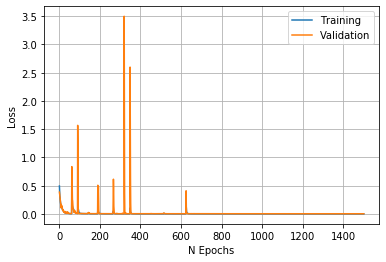

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

x_epochs=np.linspace(1,n_epoch,n_epoch).astype(dtype=int)
plt.plot(x_epochs,train_loss)
plt.plot(x_epochs,valid_loss)
plt.xlabel("N Epochs")
plt.ylabel("Loss")
plt.grid()
plt.legend(["Training","Validation"])
plt.show()

### 4.1 ROC and AUC
We will now evaluate the model using the ROC Curve and AUC. You can find more information about it at this [link](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)

Estimated AUC: 0.9422156952407754


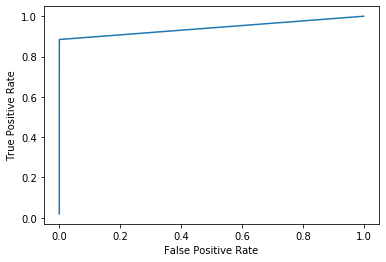

In [34]:
k=np.linspace(0,1,10)
TPR=[]
FPR=[]
for n in k:
    outputs=[]
    targets=[]
    for data,target in test_loader:
        data,target=data.cuda(),target.cuda()
        output=model(data.float())
        output=torch.sigmoid(output.cpu())
        output=list(np.where(output<n,0,1)[:])
        target=list(target.cpu().numpy())
        outputs+=output
        targets+=target

    outputs_of_model=np.stack(outputs,axis=0).squeeze().astype(dtype=int)
    targets_of_model=np.array(targets).astype(dtype=int)
    
    #detect True Negatives, False Positives, False Negatives, True Positives
    TN=np.array(targets_of_model[outputs_of_model==0]==0).sum()
    FP=np.array(targets_of_model[outputs_of_model==1]==0).sum()
    FN=np.array(targets_of_model[outputs_of_model==0]==1).sum()
    TP=np.array(targets_of_model[outputs_of_model==1]==1).sum()

    TPR.append(TP/(TP+FN))
    FPR.append(FP/(FP+TN))

#Plot True Positive Rate and False Positive Rate
plt.plot(FPR,TPR)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

AUC=0.0;
for i in range(len(TPR)-1):
    AUC+=np.abs((TPR[i]+TPR[i+1])*(FPR[i+1]-FPR[i])/2)
  
  
print("Estimated AUC: {}".format(AUC))

The AUC for a perfect model would be exactly 1. Our model achieves a pretty good result on the test set. <br /> 
Even though AUC is usually a good metric of the quality of our model, cases of anomaly detection may bear high AUC even in case of low overall model quality due to the large amount of false positives predicted by the model. F1-score calculation is, in this case, necessary.

### 4.2 F1-score
Another useful metric for the anomaly detection problem is [F1-score](https://en.wikipedia.org/wiki/F1_score) which is calculated below for a threshold of 0.5. <br />
In order for the model to be considered reliable, the F1-score should be well above 0.5 (0.75~0.8 can be considered quite good).

In [35]:
outputs=[]
targets=[]
for data,target in test_loader:
    if on_cuda:
        data,target=data.cuda(),target.cuda()
    output=model(data.float())
    output=torch.sigmoid(output.cpu())
    output=list(np.where(output<0.5,0,1)[:])
    target=list(target.cpu().numpy())
    outputs+=output
    targets+=target

outputs_of_model=np.stack(outputs,axis=0).squeeze().astype(dtype=int)
targets_of_model=np.array(targets).astype(dtype=int)


TN=np.array(targets_of_model[outputs_of_model==0]==0).sum()
FP=np.array(targets_of_model[outputs_of_model==1]==0).sum()
FN=np.array(targets_of_model[outputs_of_model==0]==1).sum()
TP=np.array(targets_of_model[outputs_of_model==1]==1).sum()


print("True Positives: {}".format(TP))
print("True Negatives: {}".format(TN))
print("False Positives: {}".format(FP))
print("False Negatives: {}".format(FN))


precision=TP/(TP+FP)
recall=TP/(TP+FN)
print("Model Precision: {}".format(precision))
print("Model Recall: {}".format(recall))

F1=2*precision*recall/(precision+recall)

print("F1-score: {}".format(F1))

True Positives: 46
True Negatives: 28421
False Positives: 8
False Negatives: 6
Model Precision: 0.8518518518518519
Model Recall: 0.8846153846153846
F1-score: 0.8679245283018868


F1-score of 0.87 is a great result!
This is only one possible solution for the present problem. Try changing the number of layers, the learning rate and all the parameters to achieve a better F1-score. <br />
In addition, some other algorithms (like random forest) may achieve even higher scores.